In [1]:
import numpy as np
import scipy as sp
import scipy.special
from KGInt import integrate, integrate_GPU
import h5py as h5
import matplotlib.pyplot as plt

%matplotlib inline

## Table

KGInt calculates $\mathcal{L}(r,\alpha)$

We need: 
\begin{equation}
\frac{1}{(2\pi)^3}\int d^3 \boldsymbol {q} e^{i\boldsymbol {q}\boldsymbol {r}}e^{-\frac{1}{2}|\boldsymbol {q}R|^\alpha}=\mathcal{L}(\boldsymbol{r}, \alpha, 2^{-\frac{1}{\alpha}}R)
\end{equation}

\begin{equation}
\mathcal{L}(\boldsymbol{r}, \alpha, R) = \frac{1}{R^3}\mathcal{L}\bigg(\frac{\boldsymbol{r}}{R}, \alpha, 1\bigg)=\frac{1}{R^3}\mathcal{L}\bigg(\frac{\boldsymbol{r}}{R}, \alpha\bigg)
\end{equation}

## Asymptotics

In [2]:
def asym_bx(x, alpha, n=10):
    s = 0.0
    for k in range(1, n+1):
        s += (-1)**(k+1)*(sp.special.gamma(alpha*k)/sp.special.gamma(k))*np.sin(0.5*np.pi*alpha*k)*(k*alpha+1)/x**(k*alpha+3)
    return s*alpha/(2*np.pi**2)

def asym_sx(x, alpha, n=10):
    s = 0.0
    for k in range(n):
        s += (sp.special.gamma((k+3)/alpha)/sp.special.gamma(k+3))*np.sin(0.5*np.pi*(k+3))*(k+2)*(k+1)*x**k
    return -s/(2*np.pi**2*alpha)

## Creating table

In [124]:
def gpu_calc(alpha, rrange, error, error_rng):
    gpu_rs         = np.linspace(rrange[0], rrange[1], 512*5, np.double)
    gpu_alphas     = np.array([alpha]*len(gpu_rs), np.double)
    gpu_errors     = np.array([error]*len(gpu_rs), np.double)
    gpu_error_rngs = np.array([error_rng]*len(gpu_rs), np.double)
    result_gpu = integrate_GPU(gpu_rs, gpu_alphas, gpu_errors, gpu_error_rngs)
    return gpu_rs, result_gpu

def cpu_calc(alpha, rrange, error, error_rng, N=32):
    cpu_rs         = np.linspace(rrange[0], rrange[1], N, np.double)
    cpu_alphas     = np.array([alpha]*len(cpu_rs), np.double)
    cpu_errors     = np.array([error]*len(cpu_rs), np.double)
    cpu_error_rngs = np.array([error_rng]*len(cpu_rs), np.double)
    result_cpu = integrate(cpu_rs, cpu_alphas, cpu_errors, cpu_error_rngs)
    return cpu_rs, result_cpu
    
    
def getLr(alpha):
    series_n   = 10
    error      = 1e-9
    error_rng  = 1e-12
    
    maxr_gpu   = alpha*10.
    rs         = np.array([maxr_gpu-0.5*i for i in range(1,8)], np.double)
    alphas     = np.array([alpha]*len(rs), np.double)
    errors     = np.array([pow(10, -min(maxr_gpu, 7))]*len(rs), np.double)
    error_rngs = np.array([1e-10]*len(rs), np.double)
    print("Find GPU r maximum! Target r max = ", rs)
    print("GPU GK error=", errors[0])
    result_gpu = integrate_GPU(rs, alphas, errors, error_rngs)
    result_cpu = integrate(rs, alphas, errors, error_rngs)
  
    gcDiff   = abs(result_gpu-result_cpu)[:,0]
    i        = np.min((np.arange(len(gcDiff))+1)*np.array(gcDiff<1e-7))
    maxr_gpu = rs[i]
    
    print("GPU maximum r = ",maxr_gpu)
    
    s_big = asym_bx(maxr_gpu, alpha, series_n)
    print("Asymptotic serie (val=%fe-5) diff at GPU (CPU val=%fe-5, GPU val=%fe-5) max. r = %fe-5"
          %(s_big*1e5, result_cpu[0,0]*1e5, result_gpu[0,0]*1e5,1e5*abs(s_big-result_cpu[0,0])))
    
    if abs(s_big-result_cpu[0,0])<abs(result_gpu[0,0]-result_cpu[0,0]):
        max_r = maxr_gpu
    else:
        print("-->Finding max_r started")
        idx = 0
        cpu_rs, result_cpu = cpu_calc(alpha, [maxr_gpu, 4*maxr_gpu], error, error_rng, N=8)
        for i in range(len(cpu_rs)):
            s_big = asym_bx(cpu_rs[i], alpha, series_n)
            if abs(s_big-result_cpu[i,0])<1e-8:
                max_r = cpu_rs[i]
                idx = i
        if not max_r:
            print("Fatal error! max_r not found in [%f, %f] range!"%(maxr_gpu, 4*maxr_gpu))
            return -1
        s_big = asym_bx(max_r, alpha, series_n)
        print("Asymptotic serie (val=%fe-5) relative diff at CPU (val=%fe-5) max. r = %fe-8"
          %(s_big*1e5, result_cpu[idx,0]*1e5,1e8*abs(s_big-result_cpu[idx,0])))
        cpu_rs, result_cpu = cpu_calc(alpha, [maxr_gpu, max_r], error, error_rng, 64)
        print("---:END")
    
    gpu_rs, result_gpu = gpu_calc(alpha, [1e-6, maxr_gpu], errors[0], error_rngs[0])
        
    s_small = asym_sx(gpu_rs[:256], alpha, series_n)
    min_idx = 0
    i = 0
    while min_idx==0:
        v       = (abs(result_gpu[:256,0]-s_small)/(result_gpu[:256,0]))<error*i
        min_idx = np.max((np.arange(len(v))+1)*v)
        i += 1
    min_r = gpu_rs[min_idx+1]
    print("Minimum r = %f, error=%fe-5 (asymptotic serie under this)"% (min_r, error*i*100000))
    
    mask = gpu_rs>=min_r
    
    result_gpu = result_gpu[mask]
    gpu_rs     = gpu_rs[mask]
    
    return min_r, max_r, gpu_rs, result_gpu, cpu_rs, result_cpu

def plot(min_r, max_r, grs, gr, crs, cr, alpha):
    plt.figure(0, (14,7))
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("r", fontsize=18)
    plt.ylabel(r"$\mathcal{L}(r, \alpha=%.2f)$"%alpha, fontsize=18)
    asym = np.linspace(min_r/5, min_r, 100)
    plt.plot(asym, asym_sx(asym,alpha), label="Asymptotics")
    plt.plot(grs, gr[:,0],'.', label="GPU result")
    plt.plot(crs, cr[:,0],'.', label="CPU result")
    asym = np.linspace(max_r, 5*max_r, 100)
    plt.plot(asym, asym_bx(asym, alpha), label="Asymptotics")
    plt.legend(fontsize=16)

In [122]:
alpha = 0.6
min_r, max_r, grs, gr, crs, cr = getLr(alpha)

Find GPU r maximum! Target r max =  [ 5.5  5.   4.5  4.   3.5  3.   2.5]
GPU GK error= 1e-06
Elapsed time: 1106.0 ms
Elapsed time: 28.0 ms
GPU maximum r =  5.0
Asymptotic serie (val=11.768801e-5) diff at GPU (CPU val=8.560924e-5, GPU val=8.560305e-5) max. r = 3.207877e-5
-->Finding max_r started
Elapsed time: 1974.0 ms
Asymptotic serie (val=0.102132e-5) relative diff at CPU (val=0.102132e-5) max. r = 0.000060e-8
Elapsed time: 14369.0 ms
---:END
Elapsed time: 1262.0 ms
Minimum r = 0.003909, error=0.093300e-5 (asymptotic serie under this)


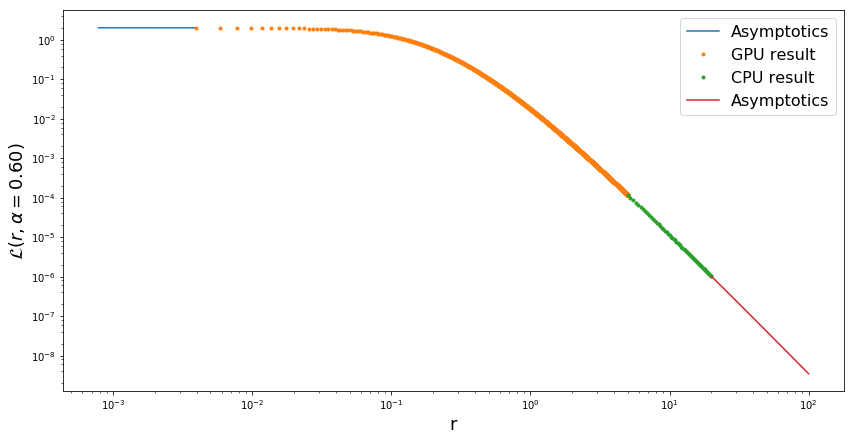

In [125]:
plot(min_r, max_r, grs, gr, crs, cr, alpha)